## COVID19 Global Forecasting (Week 1) Covid-19 全球確診死亡人數預測 第一週
- 在這一挑戰中，您將預測世界各地各個地區未來日期的確認Covid19案例的累積數量，以及導致死亡的數量。

### 評估
- 兩個 column，分別為確診人數 (ConfirmedCases)、死亡人數 (Fatalities)
- 評估指標 RMSLE

### 特徵定義
- id - 就是id。
- Province/State - 省/州/城市。
- Country/Region - 國家。
- Lat - 緯度。
- Long - 經度。
- Date - 紀錄的日期。
- ConfirmedCases - 確診人數。
- Fatalities - 死亡人數。

In [100]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import datetime as dt
import string
from google.cloud import bigquery

# 資料視覺化
import matplotlib.pyplot as plt
from matplotlib import rcParams, pyplot as plt, style as style
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [101]:
# 載入訓練資料集
train = pd.read_csv("./data/covid19-global-forecasting-week-1/train.csv")
train.head(5)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [102]:
# 載入測試資料集
test = pd.read_csv('./data/covid19-global-forecasting-week-1/test.csv')
test.head(5)

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [103]:
# 確認資料特徵類型
print(f'train dtypes:\n{train.dtypes}')
print(f'\ntrain shape: {train.shape}')
print(f'\ntest shape: {test.shape}')

train dtypes:
Id                  int64
Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object

train shape: (17892, 8)

test shape: (12212, 6)


### Missing value 缺失值檢測
> 發現只有部分國家沒有城市資料

Text(0.5, 1.0, 'Total Missing Value (%) in Train')

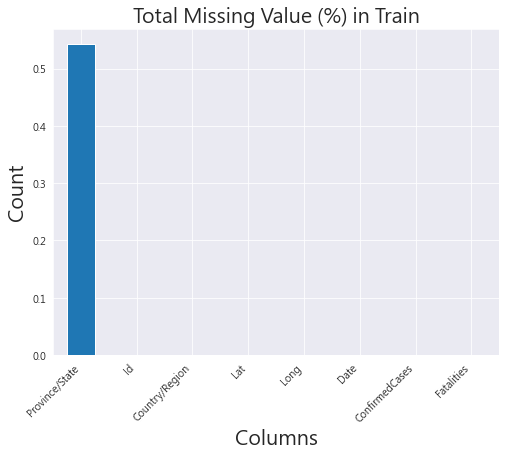

In [104]:
# 檢查缺失值
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
# missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Train", fontsize = 20)

### Outlier detect 離群值檢測
- 利用四分位距 (IQR) 來判斷離群值
- 捨去離群值後發現呼吸數會不足80，影響分析，所以決定不捨去
- 移除 pressure 為負的資料

In [105]:
# 建立異常值index陣列
outlier_indices = []

# 計算每個特徵的四分位數
for column in train.columns:
    if column in ['Id','Province/State','Country/Region','Date']:
        continue # continue：強制跳出 ❮本次❯ 迴圈，繼續進入下一圈
    Q1 = train.loc[train[column].notna(), column].quantile(0.25) # 計算第一四分位數
    Q3 = train.loc[train[column].notna(), column].quantile(0.75) # 計算第三四分位數
    
    # 四分位數間距（IQR）是第一個四分位數與第三個四分位數之間的差值, 用於檢測異常值
    IQR = Q3 - Q1
    
    # 將 1.5 x（IQR）添加到第三个四分位数。任何大于此的数字或是小於此數字都是可疑的异常值。
    outlier_step = 1.5 * IQR
    
    # 取得是異常值的 index
    outlier_index = train[(train[column] < Q1 -outlier_step) | (train[column] > Q3 + outlier_step)].index
    
    # extend方法只能加入串列，不可以是元素。它會把串列中的元素做為個別元素加進串列裡 
    # 建立判定為異常值的陣列
    outlier_indices.extend(outlier_index)
    
# 選擇包含超過 n個異常值的觀察
outlier_indices = dict(Counter(outlier_indices))           # 將異常值的資料轉為字典
outlier_counts = pd.DataFrame.from_dict(outlier_indices, orient = 'index', columns=['counts']) # 將字典轉回dataframe形式
outlier_data = train.loc[outlier_indices.keys()]       # 取得異常值字典的 key的那些 row 資料
outlier_data = pd.concat([outlier_counts, outlier_data], axis = 1) # 將異常值計數的 dataframe 與 異常資料的 dataframe 合併

print("含有離群值的列數: " + str(outlier_data.shape[0]))

outlier_data.sort_values(by = ['counts'], ascending = False).head() # 觀察

含有離群值的列數: 4343


,counts,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
692,3,993,New South Wales,Australia,-33.8688,151.2093,2020-03-24,818.0,7.0
376,3,527,NaN,Argentina,-38.4161,-63.6167,2020-03-23,266.0,4.0
676,3,977,New South Wales,Australia,-33.8688,151.2093,2020-03-08,38.0,2.0
675,3,976,New South Wales,Australia,-33.8688,151.2093,2020-03-07,28.0,1.0
674,3,975,New South Wales,Australia,-33.8688,151.2093,2020-03-06,26.0,1.0


### [ 分析目標 ]
- 透過地點、日期 來判斷確診與死亡人數
- 日期區間為 2020-01-22 至 2020-03-24
- 了解個國家確診占比後發現,中國、義大利、美國，這三國確診人數初期最多
- 中國從 2020-02-11 後人數暴增，其餘國家大約 2020-03-11 後人數暴增
- 義大利的死亡人數從 2020-03-11 後暴增，2020-03-17 超越中國成為死亡人數最多的國家

In [106]:
#觀察各國確診死亡情形
countries = train.fillna('N/A').groupby(['Country/Region'])['ConfirmedCases', 'Fatalities'].max().sort_values(by='ConfirmedCases', ascending=False)
countries.head(10)

,ConfirmedCases,Fatalities
Country/Region,,
Italy,69176.0,6820.0
China,67801.0,3160.0
Spain,39885.0,2808.0
Germany,32986.0,157.0
US,25681.0,210.0
Iran,24811.0,1934.0
France,19874.0,860.0
Switzerland,9877.0,122.0
"Korea, South",9037.0,120.0


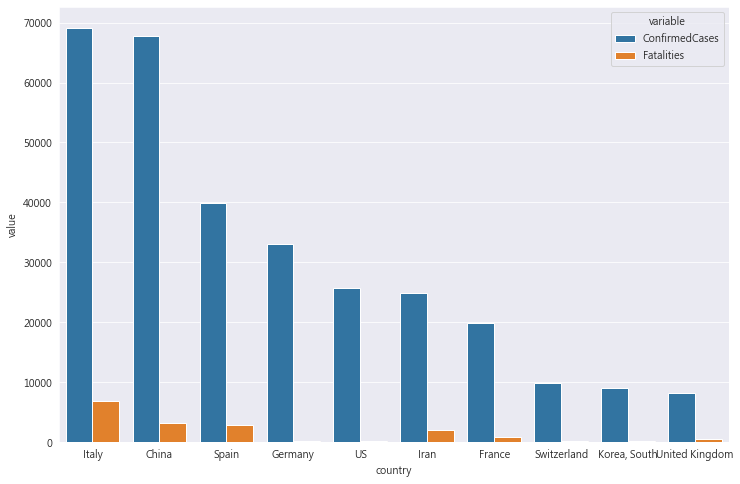

In [107]:
# 各國的紀錄
countries['country'] = countries.index

# 使用 pd.melt , 固定country欄位, 拆解 ConfirmedCases & Fatalities 欄位
df_long = pd.melt(countries, id_vars=['country'] , value_vars=['ConfirmedCases','Fatalities'])

# 取最嚴重的前十名國家
top_countries = countries.index[:10]

# 得到前十名國家的dataframe ,  isin(): 用滿足布林條件的列值來過濾資料
df_top_countries = df_long[df_long['country'].isin(top_countries)]
rcParams['figure.figsize'] = 12,8
ax = sns.barplot(x = 'country', hue="variable", y="value", data=df_top_countries)

紀錄起始時間 :2020-01-22
紀錄終止時間 :2020-03-24


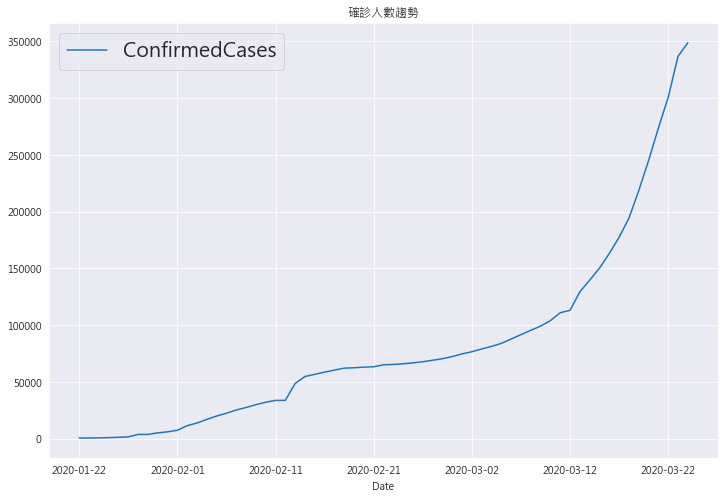

In [110]:
# 時間序列分析 (確診人數)
print("紀錄起始時間 :"+str(train.Date.min()))
print("紀錄終止時間 :"+str(train.Date.max()))

# 移除不要得特徵
cols_ConfirmedCases = ['Lat', 'Long', 'Fatalities']
times_series_ConfirmedCases = train.drop(cols_ConfirmedCases, axis=1).fillna('N/A')

# 建立日期和所有國家的確診總數的關係 
# groupby 後資料型態為 SeriesGroupBy
# SeriesGroupBy 做 .max() 或 sum() 後 變成 Series
# Series 做 .reset_index()  後 變成 DataFrame
times_series_ConfirmedCases = times_series_ConfirmedCases.groupby(['Date','Country/Region'])['ConfirmedCases'].max().reset_index()
times_series_ConfirmedCases = times_series_ConfirmedCases.set_index('Date')  # 把日期設成 index

# 確診人數加總 根據 Date 加總 ConfirmedCases
times_series_ConfirmedCases_df = times_series_ConfirmedCases.groupby('Date')['ConfirmedCases'].sum().reset_index()
times_series_ConfirmedCases_df = times_series_ConfirmedCases_df.set_index('Date')

# 查看確診人數與日期的關係
times_series_ConfirmedCases_df.plot(figsize=(15, 10), title="確診人數趨勢")
plt.legend(loc=2, prop={'size': 14})
plt.show()

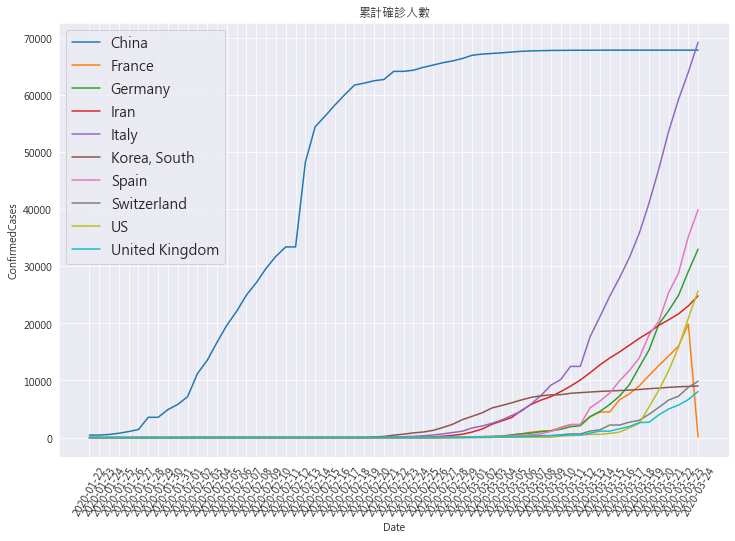

In [124]:
# 各國 確診人數與日期的關係
top_countries_ConfirmedCases = times_series_ConfirmedCases[times_series_ConfirmedCases['Country/Region'].isin(top_countries)]
top_countries_ConfirmedCases = top_countries_ConfirmedCases.reset_index()

ax = sns.lineplot(x="Date", y="ConfirmedCases", hue="Country/Region", data=top_countries_ConfirmedCases).set_title('累計確診人數')
plt.xticks(rotation=60)
plt.legend(loc=2, prop={'size': 14})

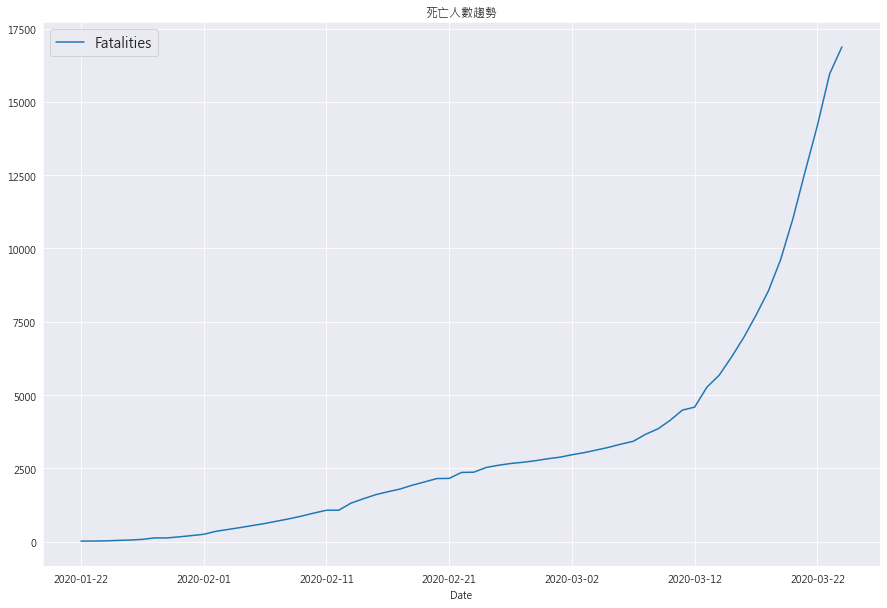

In [125]:
# 時間序列分析 (確診人數)
train.Date.min(), train.Date.max()

cols_Fatalities = ['Lat', 'Long', 'ConfirmedCases']
times_series_Fatalities = train.drop(cols_Fatalities, axis=1).fillna('N/A')

# 建立日期和所有國家的死亡總數的關係 
times_series_Fatalities = times_series_Fatalities.groupby(['Date','Country/Region'])['Fatalities'].max().reset_index()
times_series_Fatalities = times_series_Fatalities.set_index('Date')

# 死亡人數加總 根據 Date 加總 Fatalities
times_series_Fatalities_df = times_series_Fatalities.groupby('Date')['Fatalities'].sum().reset_index()
times_series_Fatalities_df = times_series_Fatalities_df.set_index('Date')

# 查看確診人數與日期的關係
times_series_Fatalities_df.plot(figsize=(15, 10), title="死亡人數趨勢")
plt.legend(loc=2, prop={'size':14})
plt.show()

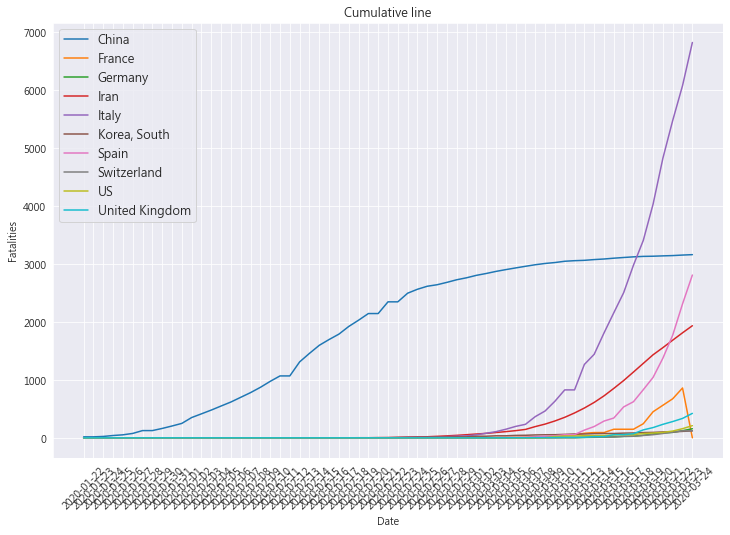

In [126]:
# 各國 確診人數與日期的關係
top_countries_Fatalities = times_series_Fatalities[times_series_Fatalities['Country/Region'].isin(top_countries)]
top_countries_Fatalities = top_countries_Fatalities.reset_index()

ax = sns.lineplot(x="Date", y="Fatalities", hue="Country/Region", data=top_countries_Fatalities).set_title('Cumulative line')
plt.xticks(rotation=45)
plt.legend(loc=2, prop={'size': 12})

#### 1. 特徵建構
- 轉換時間特徵

In [127]:
# 將時間特徵轉為數字 , 因為日期一天一天往後 可以當作大小判斷
train["Date"] = train["Date"].apply(lambda x: x.replace("-",""))
train["Date"]  = train["Date"].astype(int)
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,20200122,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,20200123,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,20200124,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,20200125,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,20200126,0.0,0.0


In [128]:
# 拿掉 NaN 值
train = train.drop(['Province/State'],axis=1)
train = train.dropna()
train.isnull().sum()

Id                0
Country/Region    0
Lat               0
Long              0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [129]:
# 測試集 同步
test["Date"] = test["Date"].apply(lambda x: x.replace("-",""))
test["Date"]  = test["Date"].astype(int)
# test = test.dropna()
test.isnull().sum()

ForecastId           0
Province/State    6622
Country/Region       0
Lat                  0
Long                 0
Date                 0
dtype: int64

<AxesSubplot:>

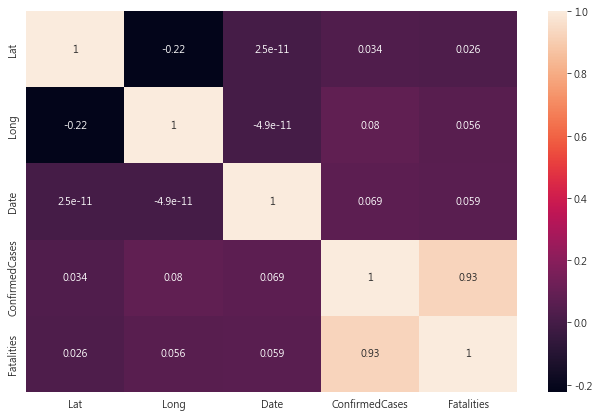

In [130]:
# 相關性分析
train_corr = train.drop(['Id'],axis=1)
corr = train_corr.corr()
plt.figure(figsize=(11,7))
sns.heatmap(corr, annot=True)

In [131]:
# 針對地區做 one-hot encode
train = pd.concat([train, pd.get_dummies(train["Country/Region"])], axis=1)
test = pd.concat([test, pd.get_dummies(test["Country/Region"])], axis=1)

## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞
- 先預測確診人數，再預測死亡人數

In [132]:
x = train.drop(['Id','Country/Region','ConfirmedCases','Fatalities'],axis=1)

y1 = train[['ConfirmedCases']]
y2 = train[['Fatalities']]

x_test = test.drop(['ForecastId','Province/State','Country/Region'],axis=1)

print(f'x shape: {x.shape}')
print(f'y1 shape: {y1.shape}')
print(f'y2 shape: {y2.shape}')
print(f'test shape: {x_test.shape}')

x shape: (17892, 166)
y1 shape: (17892, 1)
y2 shape: (17892, 1)
test shape: (12212, 166)


In [133]:
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [134]:
print(f'x shape: {x.shape}')
print(f'y1 shape: {y1.shape}')
print(f'y2 shape: {y2.shape}')
print(f'test shape: {x_test.shape}')

x shape: (17892, 166)
y1 shape: (17892, 1)
y2 shape: (17892, 1)
test shape: (12212, 166)


In [135]:
# 訓練 確診人數
rf.fit(x, y1)
pred1 = rf.predict(x)
pred1 = pd.DataFrame(pred1)
scroe = rmsle(y1, pred1 )
scroe

2279.0148557033754

In [136]:
# 訓練 確診人數
rf.fit(x,y1)
pred1 = rf.predict(x_test)
pred1 = pd.DataFrame(pred1)

In [137]:
# 訓練 死亡人數
rf.fit(x,y2)
pred2 = rf.predict(x_test)
pred2 = pd.DataFrame(pred2)

In [138]:
sub = pd.read_csv('./data/covid19-global-forecasting-week-1/submission.csv')
submission = pd.DataFrame()
submission['ForecastId'] = sub['ForecastId']
submission['ConfirmedCases'] = pred1
submission['Fatalities'] = pred2 
# submission["ConfirmedCases"] = submission["ConfirmedCases"].astype(int)
# submission["Fatalities"] = submission["Fatalities"].astype(int)

submission.to_csv('./data/covid19-global-forecasting-week-1/submission_blend.csv', index = False)